# Events Table Stratified

__Description__: 
A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: 1 JSON file with the Hydro 1-4 event hyetographs and 1 JSON file with event weights. Additionally 4 DSS files with the Hydro 1-4 hyetograph information is prepared. Intermediate csv and excel files are saved for reference.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import hydromet_JSON_to_DSS
import mean_frequency_curve
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 56  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 21.9  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 0.914  # Aerial reduction factor
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hydrology_IDs = [1, 2, 3, 4]  # ID's of the different hydrology scenarios considered. 


## Mean curve parameters:
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits

## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'Concord'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'HUC_08Concord'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_input_table = f'Mean_Curve_Input_{Project_Area}.csv'
precip_mean_curve_table = f'MeanCurve_{Project_Area}.csv'
CN_Distribution = 'NEH630_Table_10_1.json'
nrcs_precip_table = '{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
precip_mean_curve_input_table_dir = outputs_dir/precip_mean_curve_input_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False

## Excess rainfall parameters:
durations = [6, 12, 24, 96]  # Calculate multiple durations 

## Options:
save_dss = False
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'24': 2, '24': 2, '24': 2, '24': 2}  # Run durations in days

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_input_table_dir = pl.Path(precip_mean_curve_input_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.669244,2.140739,3.279545
2,3.269051,2.618799,4.020598


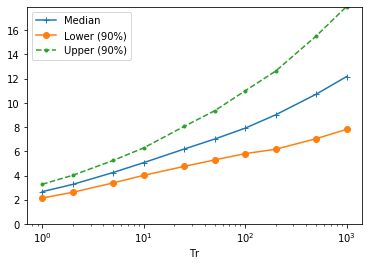

In [4]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [5]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

../../core\hydromet_stratified.py:61: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.866854,2.307226,3.506552
sigma,0.637639,0.563565,0.739205
xi,-0.167013,-0.057439,-0.262339


#### Plot fitted GEV distribution and NOAA data:

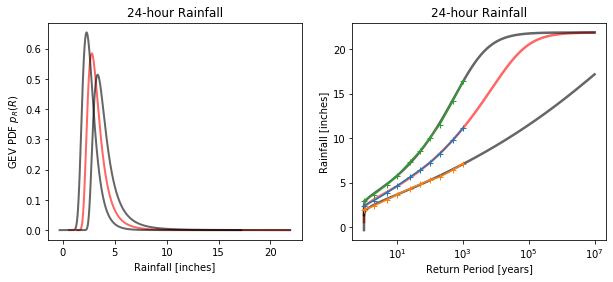

In [6]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP, 'Rainfall')

---
## Hydrology 1

In [7]:
Return_Intervals_Hydro1 = np.array([10, 25, 50, 100, 500])  # Hydrology 1 Return intervals for calculating runoff values.
GEV_parameters_M = df_GEV_parameters_M.values.transpose()[0]
df_weights_rainfall = weights_Rainfall(Return_Intervals_Hydro1, GEV_parameters_M, PMP, RI_upper_bound, raw_precip_reduced, 'Median', CN, mu)
df_weights_rainfall['Event Weight'].iloc[-2] = df_weights_rainfall['Event Weight'].iloc[-2]+df_weights_rainfall['Event Weight'].iloc[-1] # Add last event weight to the last event listed in the return intervals array
df_weights_rainfall = df_weights_rainfall[:-1].copy() # Drop the last event containing the rainfall amount of to the PMP
df_weights_rainfall

,Bin Floor,Bin Ceiling,Event Weight,Median,Runoff
10,6.762616,16.794294,0.088328,4.627918,0.856006
25,16.794294,42.395905,0.035957,5.651490,1.394539
50,42.395905,60.072752,0.006941,6.407113,1.842288
100,60.072752,210.832631,0.011903,7.229514,2.368730
500,210.832631,3700.000000,0.004743,9.787775,4.199981


In [8]:
#events and excess precip curves
prep_curves = precip_to_runoff_h1(Return_Intervals_Hydro1,nrcs_precip_table_dir,
                     raw_precip_reduced,df_weights_rainfall,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

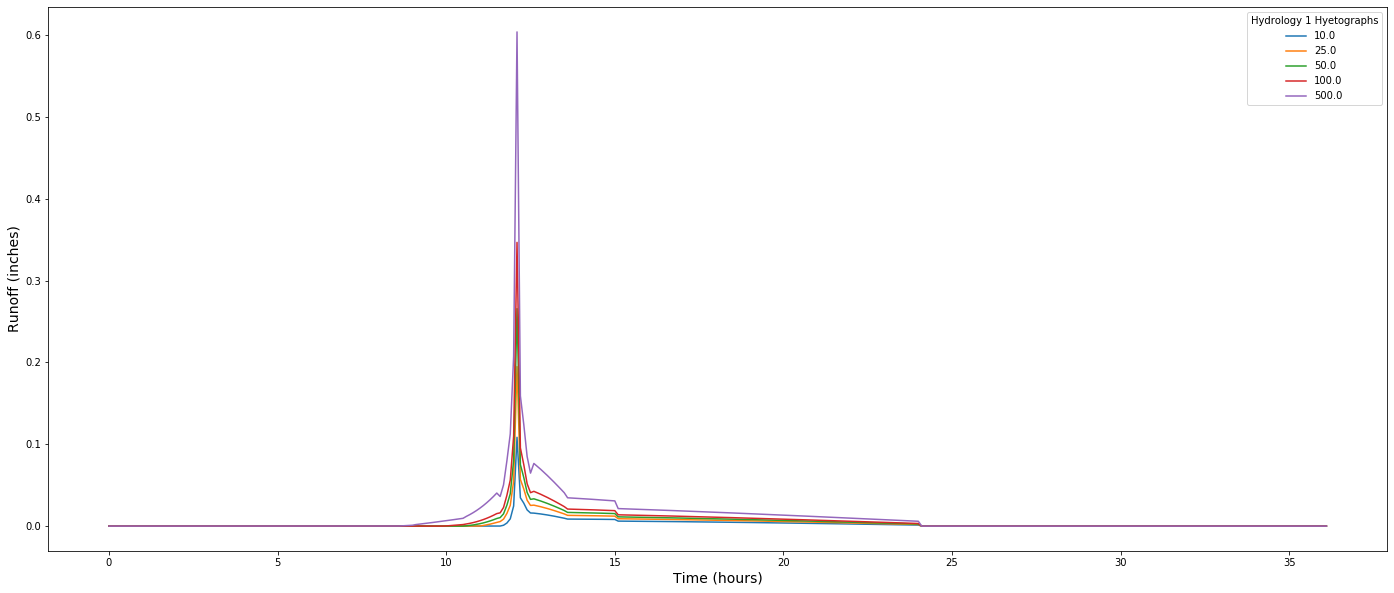

In [9]:
## test plot:
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [10]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 1
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) 
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E1001': '0.08832774034073240244',
 'E1002': '0.03595684881894143509',
 'E1003': '0.00694070135673354946',
 'E1004': '0.01190338338771757334',
 'E1005': '0.00474309880833541971'}

In [11]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E1001,E1002,E1003,E1004,E1005
hours,,,,,
0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0


In [12]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E1001,0.08832774034073240244
E1002,0.03595684881894143509
E1003,0.00694070135673354946
E1004,0.01190338338771757334
E1005,0.00474309880833541971


### Save Data

##### To CSV:

In [13]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [14]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

---
## Hydrology 2

---
## Mean Curve Calculation
#### Data for calculating the mean curve:

In [15]:
return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_data.head(2)

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.439689,1.956636,2.997504,0.134130,0.125173,0.134130,0.891870
1.01,2.006265,1.482115,2.575274,0.184076,0.151782,0.184076,0.696275


#### Input for calculating the mean curve:

In [16]:
mean_curve_data = mean_curve_input_table(CL, return_interval_data, PMP, precip_mean_curve_input_table_dir)
mean_curve_data.head(2)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,20.878909,21.111104,21.212154,21.449258,21.552452,21.656303,21.717358,21.760816,21.794603,21.822261,21.845682,21.865996,21.883936,21.892177,21.898467,21.899235,21.899847
2.000000e-07,20.386522,20.726519,20.875247,21.226047,21.379523,21.534467,21.625792,21.690898,21.741576,21.783100,21.818290,21.848833,21.875821,21.888224,21.897692,21.898849,21.899770


##### Calculate the mean precipitation curve:

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



,P_Mean_in,P_Median_in
AEP,,
0.9,2.238766,2.370536
0.5,3.082503,2.987913


C:\Users\cusmith\2dble2\pfra-hydromet\notebooks\pluvial\Outputs - already exists



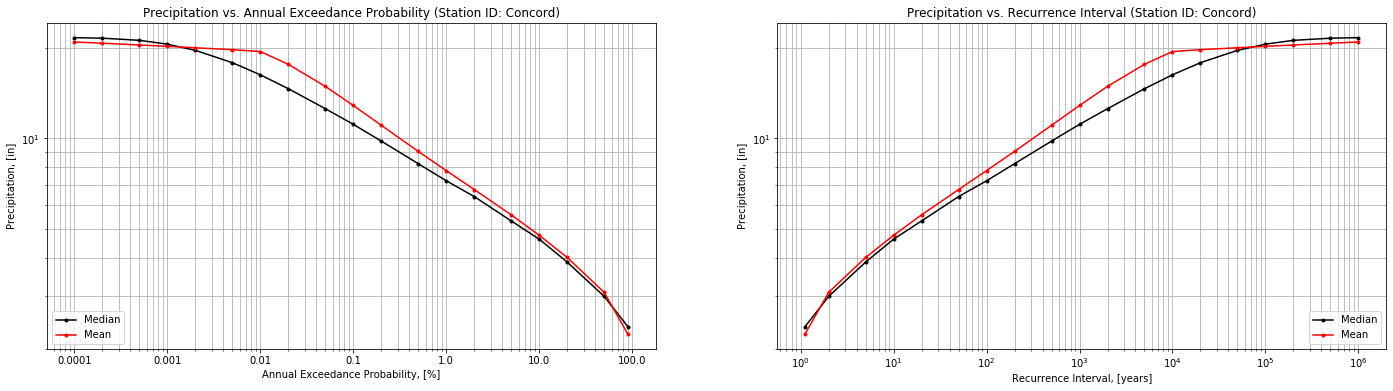

In [17]:
df = mean_frequency_curve.main(Project_Area, precip_mean_curve_input_table_dir, outputs_dir, data_type = 'P', round_decimals = 6)

---
### Load Mean Curve:

,P_Mean_in,P_Median_in
Tr,,
1.111111,2.238766,2.370536
2.000000,3.082503,2.987913


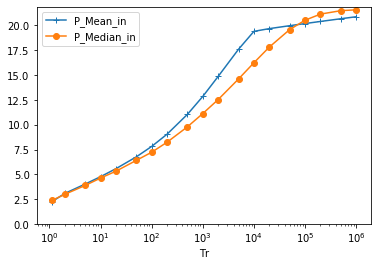

In [18]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

In [19]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

../../core\hydromet_stratified.py:61: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV P_Mean_in
mu,2.866854,2.307226,3.506552,2.787577
sigma,0.637639,0.563565,0.739205,0.642289
xi,-0.167013,-0.057439,-0.262339,-0.224061


#### Plot fitted GEV distribution and mean precipitation curve:

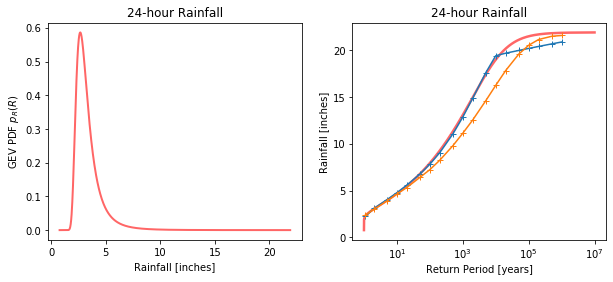

In [20]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP, 'Rainfall')

### Hydrology 2 Events:

In [21]:
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', CN, mu)
df_weights_rainfall.head(2)

,Bin Floor,Bin Ceiling,Event Weight,P_Mean_in,Runoff
2.0,1.257984,4.098530,0.550932,3.082503,0.243733
5.0,4.098530,6.273013,0.084577,4.023689,0.583310


In [22]:
#events and excess precip curves
hydro_events = df_weights_rainfall.index.to_numpy().tolist()
prep_curves = precip_to_runoff_h2(hydro_events,nrcs_precip_table_dir,df_weights_rainfall,df_weights_rainfall,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

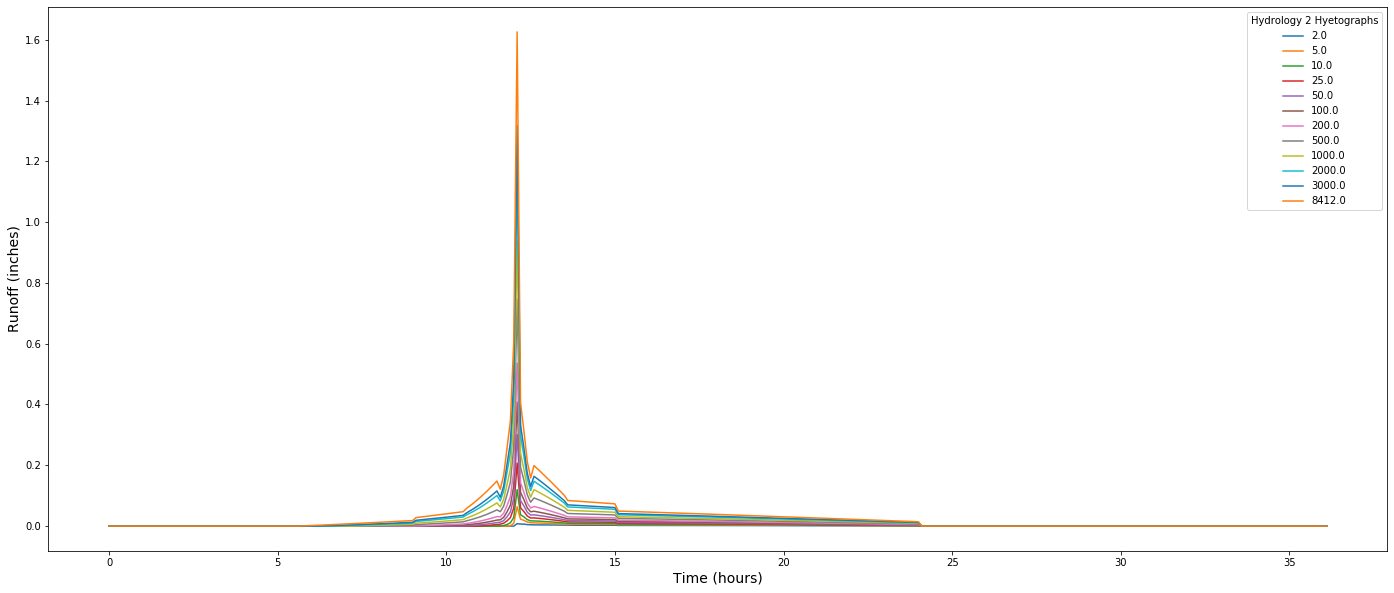

In [23]:
#graph
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 2 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [24]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 2
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro[k]

renamed_weights

{'E2001': '0.55093247566341640997',
 'E2002': '0.08457690203857537448',
 'E2003': '0.10737170841662235787',
 'E2004': '0.02275375753262222356',
 'E2005': '0.01707934544991268622',
 'E2006': '0.00423480421387190283',
 'E2007': '0.00536782633492621612',
 'E2008': '0.00114670589777869712',
 'E2009': '0.00085106954652861065',
 'E2010': '0.00020810990680566170',
 'E2011': '0.00012942433744518470',
 'E2012': '0.00027027027027027027'}

In [25]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,E2011,E2012
hours,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.55093247566341640997
E2002,0.08457690203857537448
E2003,0.10737170841662235787
E2004,0.02275375753262222356
E2005,0.01707934544991268622
E2006,0.00423480421387190283
E2007,0.00536782633492621612
E2008,0.00114670589777869712
E2009,0.00085106954652861065
E2010,0.00020810990680566170


## Save

##### To CSV:

In [27]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [28]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

---
## Hydrology 3:
### Retrieve Max Potential Retention Variability and Distribution Parameters:

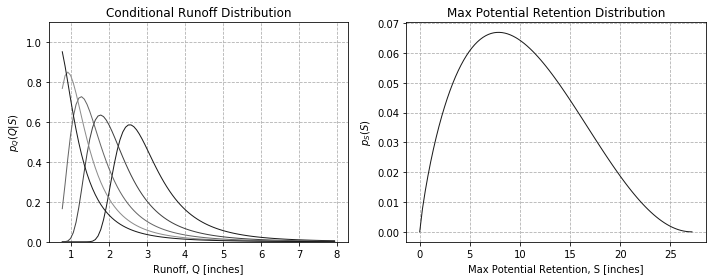

In [29]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
fitted_cn['mu'] = mu

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1.0/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)

plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

#### Calculate the error in the numerical CDF evaluated at PMP:

In [30]:
## Error between the integral approach (based on summation integration) and the actual value:
error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[1], error_PQ))


Probability of zero runoff = 0.19851730587166955
Error in calculation of Probabilibity of zero runoff = 2.475243683213065e-09
Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = 6.899647660352226e-05


### Determine Runoff Values and Weights:
#### Fit GEV to runoff data (find GEV parameters):

In [31]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
df_GEV_parameters_R

../../core\hydromet_stratified.py:61: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Runoff
mu,0.227578
sigma,0.377456
xi,-0.268778


#### Plot fitted rainfall and runoff GEV distributions:

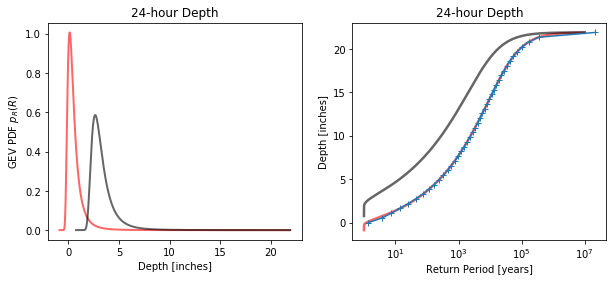

In [32]:
plot_GEV_precip_curves(df_runoff, pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1), PMP, 'Depth')

#### Runoff weights:

In [33]:
df_weights_runoff = runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
df_weights_runoff.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.246504,4.112063,0.559057,0.372946
5,4.112063,6.240748,0.082950,0.924803


#### Plot runoff distribution:

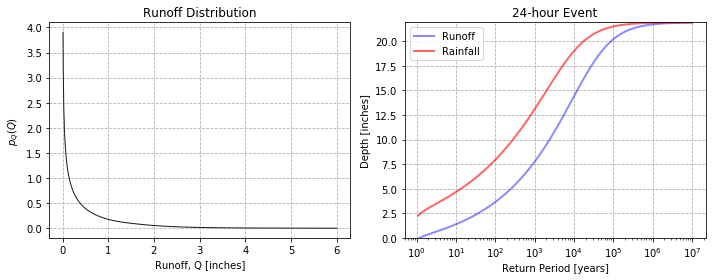

In [34]:
plot_runoff_distributions_final(GEV_parameters_E, GEV_parameters_R, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

#### Plot maximum potential distribution conditional on runoff:

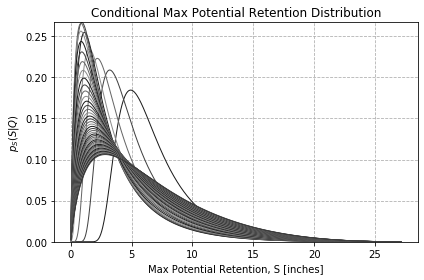

In [35]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

### Calculate Runoff and Corresponding Max Potential Retention and Rainfall:

In [36]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR1.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.246504,4.112063,0.559057,0.372946,7.652280,3.416534,6.945060,3.195640
5,4.112063,6.240748,0.082950,0.924803,5.376709,3.815069,4.500434,3.454337


### Hydrology 3 Events:
- For each runoff value, two events are considered, a high max potential retention and a low max potential retention

In [37]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR2.head(10)

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall (Lower 50%),Avg. S (Upper 50%),Rainfall (Upper 50%)
2,0.279528,0.372946,5.406218,2.699847,9.898342,4.096508
5,0.041475,0.924803,3.169305,2.869620,7.584113,4.667648
10,0.054166,1.394355,2.233614,3.041401,6.217766,4.966590
25,0.011244,2.140256,1.417257,3.397709,5.543616,5.785779
50,0.008631,2.829764,1.179787,3.961773,5.857486,6.896507
100,0.002064,3.654880,1.214712,4.859498,6.249994,8.194324
200,0.002716,4.643604,1.360313,6.015490,6.684791,9.694677
500,0.000563,6.254188,1.620352,7.913530,7.298328,12.031478
1000,0.000431,7.741935,1.835773,9.641531,7.775630,14.096896
2000,0.000103,9.486523,2.054771,11.634275,8.248975,16.430618


In [38]:
#formatting
hydro_events_orig = list(df_runoff_SR2.index)
relabel_U = [str(hyetograph)+'_U' for hyetograph in hydro_events_orig]
relabel_L = [str(hyetograph)+'_L' for hyetograph in hydro_events_orig]

df_runoff_SR2_U = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Upper 50%)', 'Rainfall (Upper 50%)']].copy()
df_runoff_SR2_U.rename(columns = {'Avg. S (Upper 50%)': 'Avg. S', 'Rainfall (Upper 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_U.index = relabel_U

df_runoff_SR2_L = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Lower 50%)',  'Rainfall (Lower 50%)']].copy()
df_runoff_SR2_L.rename(columns = {'Avg. S (Lower 50%)': 'Avg. S', 'Rainfall (Lower 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_L.index = relabel_L

df_weights_rainfall = df_runoff_SR2_U.append(df_runoff_SR2_L).sort_values(by=['Runoff'])
df_weights_rainfall.head(2)

,Event Weight,Runoff,Avg. S,Rainfall
2_U,0.279528,0.372946,9.898342,4.096508
2_L,0.279528,0.372946,5.406218,2.699847


In [39]:
#events and excess precip curves
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(), df_runoff_SR2.index.to_numpy())))
prep_curves = precip_to_runoff_h3(RI_list,nrcs_precip_table_dir, df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

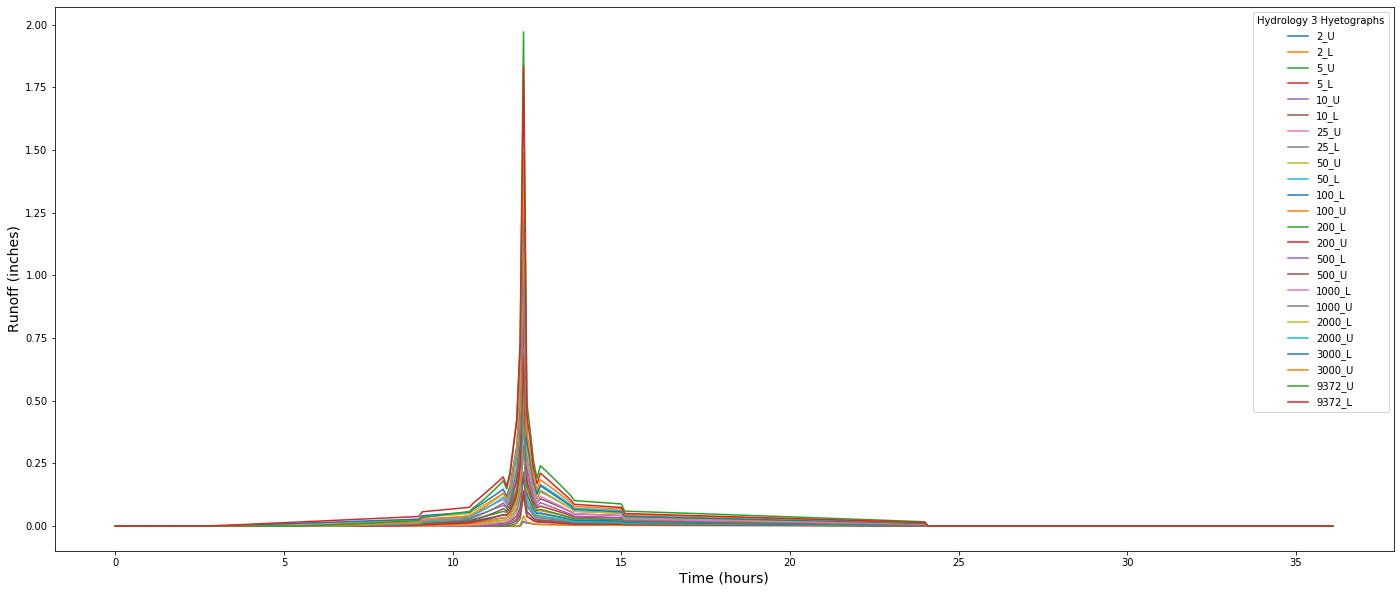

In [40]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydrology 3 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot();

In [41]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 3
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E3001': '0.27952830484799473520',
 'E3002': '0.27952830484799473520',
 'E3003': '0.04147487831045901241',
 'E3004': '0.04147487831045901241',
 'E3005': '0.05416557536615863866',
 'E3006': '0.05416557536615863866',
 'E3007': '0.01124396568567020450',
 'E3008': '0.01124396568567020450',
 'E3009': '0.00863121308417636943',
 'E3010': '0.00863121308417636943',
 'E3011': '0.00206395061717993232',
 'E3012': '0.00206395061717993232',
 'E3013': '0.00271567351264221084',
 'E3014': '0.00271567351264221084',
 'E3015': '0.00056332553841854818',
 'E3016': '0.00056332553841854818',
 'E3017': '0.00043139331885121395',
 'E3018': '0.00043139331885121395',
 'E3019': '0.00010276939981121886',
 'E3020': '0.00010276939981121886',
 'E3021': '0.00006559939401702510',
 'E3022': '0.00006559939401702510',
 'E3023': '0.00013513513513513514',
 'E3024': '0.00013513513513513514'}

In [42]:
renamed_curves = final_curves.rename(columns=rename_map).copy()

renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E3001,E3002,E3003,E3004,E3005,E3006,E3007,E3008,E3009,E3010,...,E3015,E3016,E3017,E3018,E3019,E3020,E3021,E3022,E3023,E3024
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights.head(2)

,Weight
E3001,0.27952830484799473520
E3002,0.27952830484799473520


## Save

##### To CSV:

In [44]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [45]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

## Hydrology 4

In [46]:
#events and excess precip curves
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(), df_runoff_SR2.index.to_numpy())))
prep_curves, prep_weights = precip_to_runoff_h4(RI_list,atlas14_precip_table_dir,
                     df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

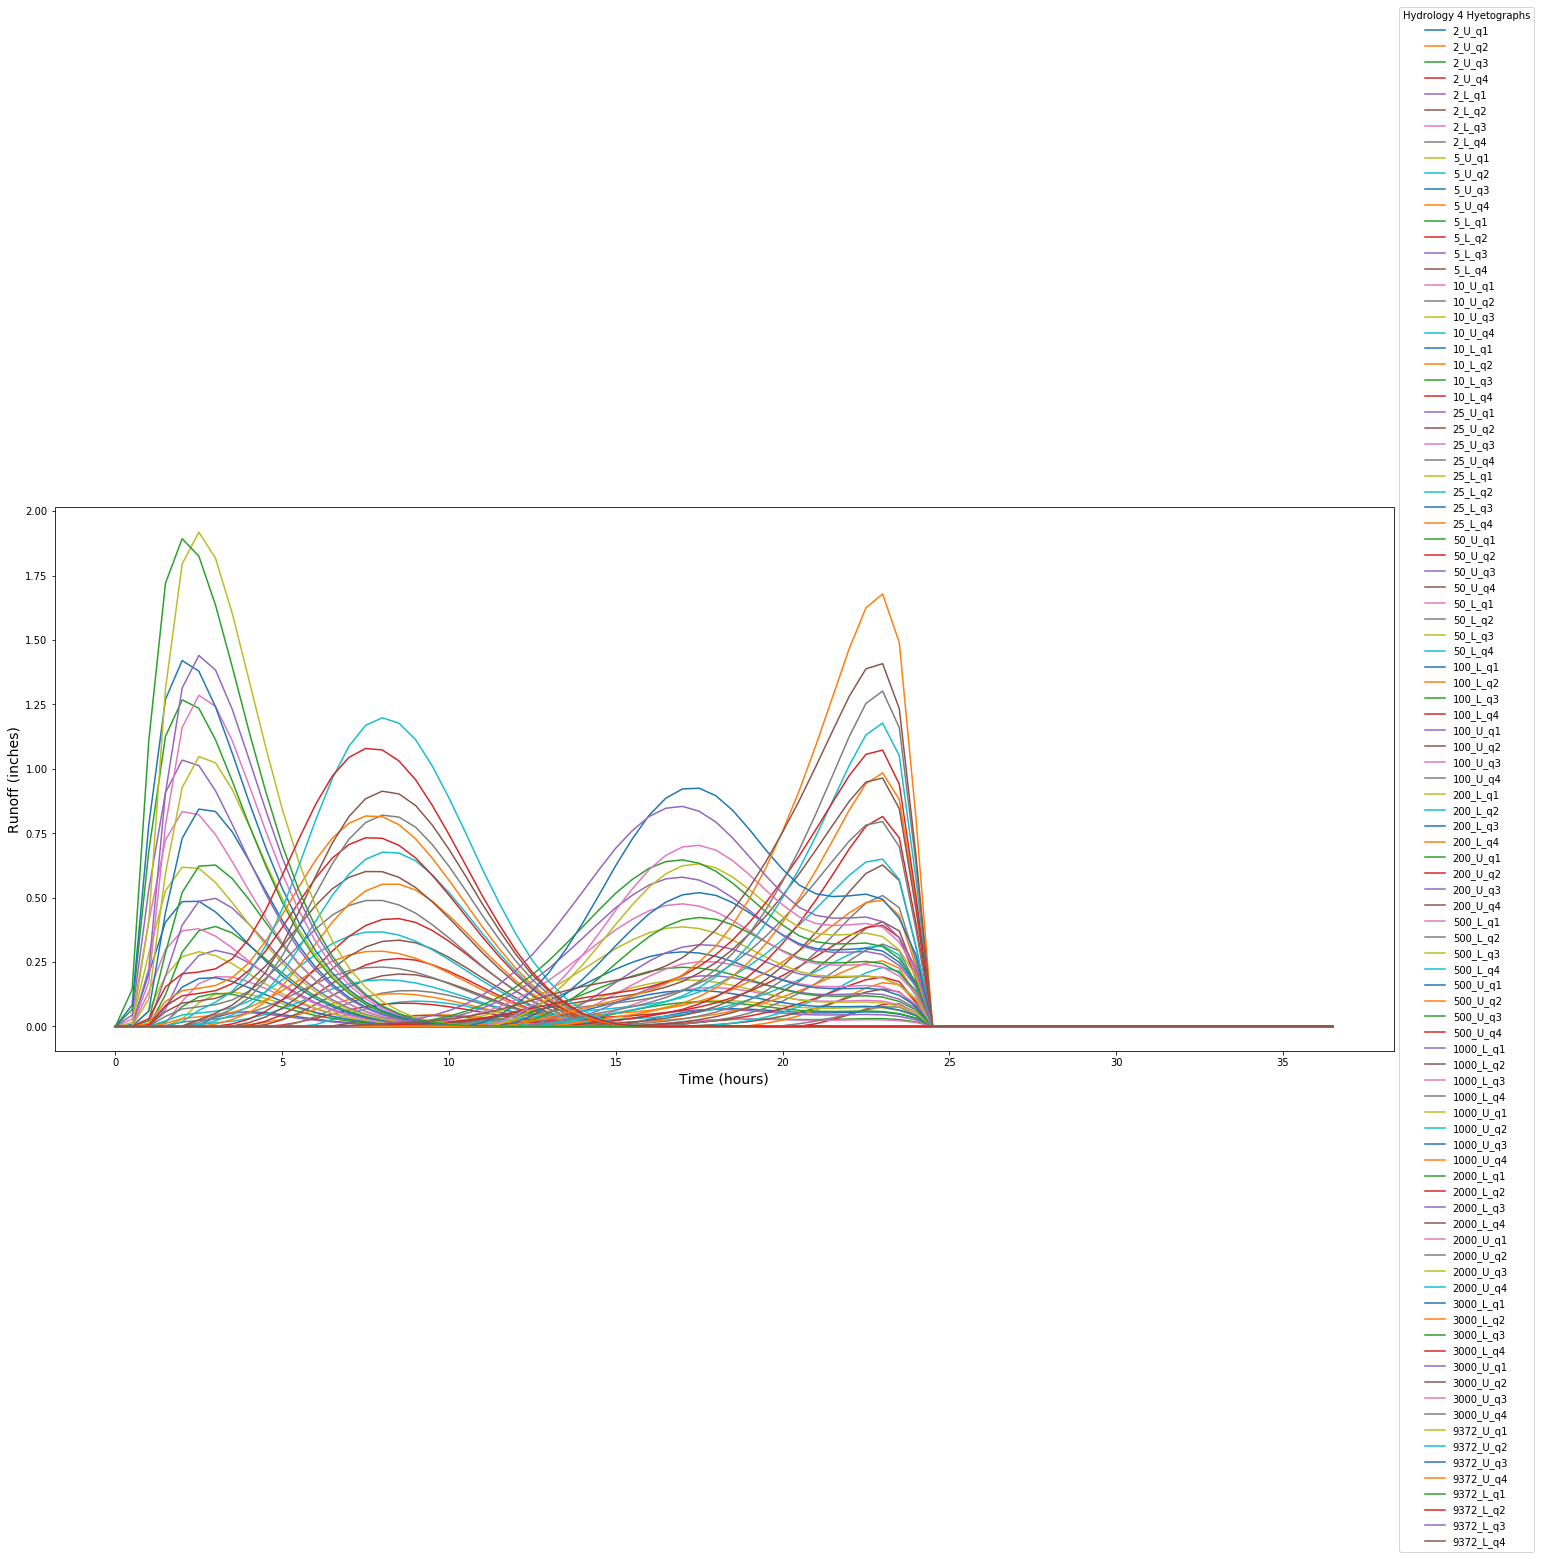

In [47]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydrology 4 Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [48]:
Event_Weights_Hydro = prep_weights['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 4
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro[k]
    
renamed_weights

{'E4001': '0.06429151011503879409',
 'E4002': '0.08665377450287836680',
 'E4003': '0.08106320840591846322',
 'E4004': '0.04751981182415911109',
 'E4005': '0.06429151011503879409',
 'E4006': '0.08665377450287836680',
 'E4007': '0.08106320840591846322',
 'E4008': '0.04751981182415911109',
 'E4009': '0.00953922201140557265',
 'E4010': '0.01285721227624229447',
 'E4011': '0.01202771471003311228',
 'E4012': '0.00705072931277803301',
 'E4013': '0.00953922201140557265',
 'E4014': '0.01285721227624229447',
 'E4015': '0.01202771471003311228',
 'E4016': '0.00705072931277803301',
 'E4017': '0.01245808233421648661',
 'E4018': '0.01679132836350917882',
 'E4019': '0.01570801685618600577',
 'E4020': '0.00920814781224696920',
 'E4021': '0.01245808233421648661',
 'E4022': '0.01679132836350917882',
 'E4023': '0.01570801685618600577',
 'E4024': '0.00920814781224696920',
 'E4025': '0.00258611210770414704',
 'E4026': '0.00348562936255776340',
 'E4027': '0.00326075004884435887',
 'E4028': '0.001911474166563

In [49]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E4001,E4002,E4003,E4004,E4005,E4006,E4007,E4008,E4009,E4010,...,E4087,E4088,E4089,E4090,E4091,E4092,E4093,E4094,E4095,E4096
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
0.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.143147,0.000000,0.0,0.0
1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.408464,0.000000,0.0,0.0,1.109350,0.029931,0.0,0.0
1.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.309737,0.000000,0.0,0.0,1.720184,0.153461,0.0,0.0
2.0,0.000000,0.0,0.0,0.0,0.000929,0.0,0.0,0.0,0.028087,0.0,...,0.0,0.0,1.794862,0.018172,0.0,0.0,1.892791,0.204314,0.0,0.0
2.5,0.005769,0.0,0.0,0.0,0.024395,0.0,0.0,0.0,0.091595,0.0,...,0.0,0.0,1.918038,0.061835,0.0,0.0,1.825237,0.211119,0.0,0.0
3.0,0.035205,0.0,0.0,0.0,0.045851,0.0,0.0,0.0,0.124441,0.0,...,0.0,0.0,1.817083,0.093964,0.0,0.0,1.635295,0.223250,0.0,0.0
3.5,0.052391,0.0,0.0,0.0,0.054254,0.0,0.0,0.0,0.132445,0.0,...,0.0,0.0,1.603821,0.136240,0.0,0.0,1.396395,0.262603,0.0,0.0
4.0,0.056745,0.0,0.0,0.0,0.053735,0.0,0.0,0.0,0.124471,0.0,...,0.0,0.0,1.345945,0.206217,0.0,0.0,1.147754,0.339518,0.0,0.0


In [50]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights.head(96)

,Weight
E4001,0.06429151011503879409
E4002,0.08665377450287836680
E4003,0.08106320840591846322
E4004,0.04751981182415911109
E4005,0.06429151011503879409
...,...
E4092,0.00002297297297297298
E4093,0.00003108108108108108
E4094,0.00004189189189189189
E4095,0.00003918918918918919


## Save

##### To CSV:

In [51]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [52]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

### Save to JSON and DSS

#### Runoff Forcing Data

In [53]:
excess_dic = combine_results_stratified('Excess_Rainfall', outputs_dir, BCN, duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(excess_dic, f)
    
forcing = '{0}_{1}_{2}'.format(Project_Area, Pluvial_Model, BCN)
jsonname = '{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN)
hydromet_JSON_to_DSS.main(outputs_dir, outputs_dir, bin_dir, forcing, jsonname, scaling = True, remove_temp_files = True, display_print = True)


Converting Concord_P01_HUC_08Concord.json to DSS...
Dss File written to C:\Users\cusmith\2dble2\pfra-hydromet\notebooks\pluvial\Outputs\Concord_P01_HUC_08Concord_H01.dss
Dss File written to C:\Users\cusmith\2dble2\pfra-hydromet\notebooks\pluvial\Outputs\Concord_P01_HUC_08Concord_H02.dss
Dss File written to C:\Users\cusmith\2dble2\pfra-hydromet\notebooks\pluvial\Outputs\Concord_P01_HUC_08Concord_H03.dss
Dss File written to C:\Users\cusmith\2dble2\pfra-hydromet\notebooks\pluvial\Outputs\Concord_P01_HUC_08Concord_H04.dss


#### Weights

In [54]:
weights_dic = combine_results_stratified('Weights',  outputs_dir, BCN, duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(weights_dic, f)

---
## End